# **LUNG CANCER DIAGNOSIS USING MULTI RISK FACTOR ANALYSIS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_validate, StratifiedKFold

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/cancer patient data sets.csv')

# **DATASET DESCRIPTION**

**Dataset size**

In [ ]:
dataset.shape

(1000, 26)

# **Column name	Description**<br>
>**Age:**	The age of the patient. (Numeric)<br>
>**Gender:**	The gender of the patient. (Categorical)<br>
>**Air Pollution**	The level of air pollution exposure of the patient. (Categorical)<br>
>**Alcohol use**	The level of alcohol use of the patient. (Categorical)<br>
>**Dust Allergy**	The level of dust allergy of the patient. (Categorical)<br>
>**OccuPational Hazards**	The level of occupational hazards of the patient. (Categorical)<br>
>**Genetic Risk**	The level of genetic risk of the patient. (Categorical)<br>
>**chronic Lung Disease**	The level of chronic lung disease of the patient. (Categorical)<br>
>**Balanced Diet**	The level of balanced diet of the patient. (Categorical)<br>
>**Obesity**	The level of obesity of the patient. (Categorical)<br>
>**Smoking**	The level of smoking of the patient. (Categorical)<br>
>**Passive Smoker**	The level of passive smoker of the patient. (Categorical)<br>
>**Chest Pain**	The level of chest pain of the patient. (Categorical)<br>
>**Coughing of Blood**	The level of coughing of blood of the patient. (Categorical)<br>
>**Fatigue**	The level of fatigue of the patient. (Categorical)<br>
>**Weight Loss**	The level of weight loss of the patient. (Categorical)<br>
>**Shortness of Breath**	The level of shortness of breath of the patient. (Categorical)<br>
>**Wheezing**	The level of wheezing of the patient. (Categorical)<br>
>**Swallowing Difficulty**	The level of swallowing difficulty of the patient. (Categorical)<br>
>**Clubbing of Finger Nails**	The level of clubbing of finger nails of the patient. (Categorical)<br>

In [ ]:
dataset.columns

Index(['index', 'Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use',
       'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking',
       'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue',
       'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring', 'Level'],
      dtype='object')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1000 non-null   int64 
 1   Patient Id                1000 non-null   object
 2   Age                       1000 non-null   int64 
 3   Gender                    1000 non-null   int64 
 4   Air Pollution             1000 non-null   int64 
 5   Alcohol use               1000 non-null   int64 
 6   Dust Allergy              1000 non-null   int64 
 7   OccuPational Hazards      1000 non-null   int64 
 8   Genetic Risk              1000 non-null   int64 
 9   chronic Lung Disease      1000 non-null   int64 
 10  Balanced Diet             1000 non-null   int64 
 11  Obesity                   1000 non-null   int64 
 12  Smoking                   1000 non-null   int64 
 13  Passive Smoker            1000 non-null   int64 
 14  Chest Pain               

# **Distribution of subcategory of each risk factor**

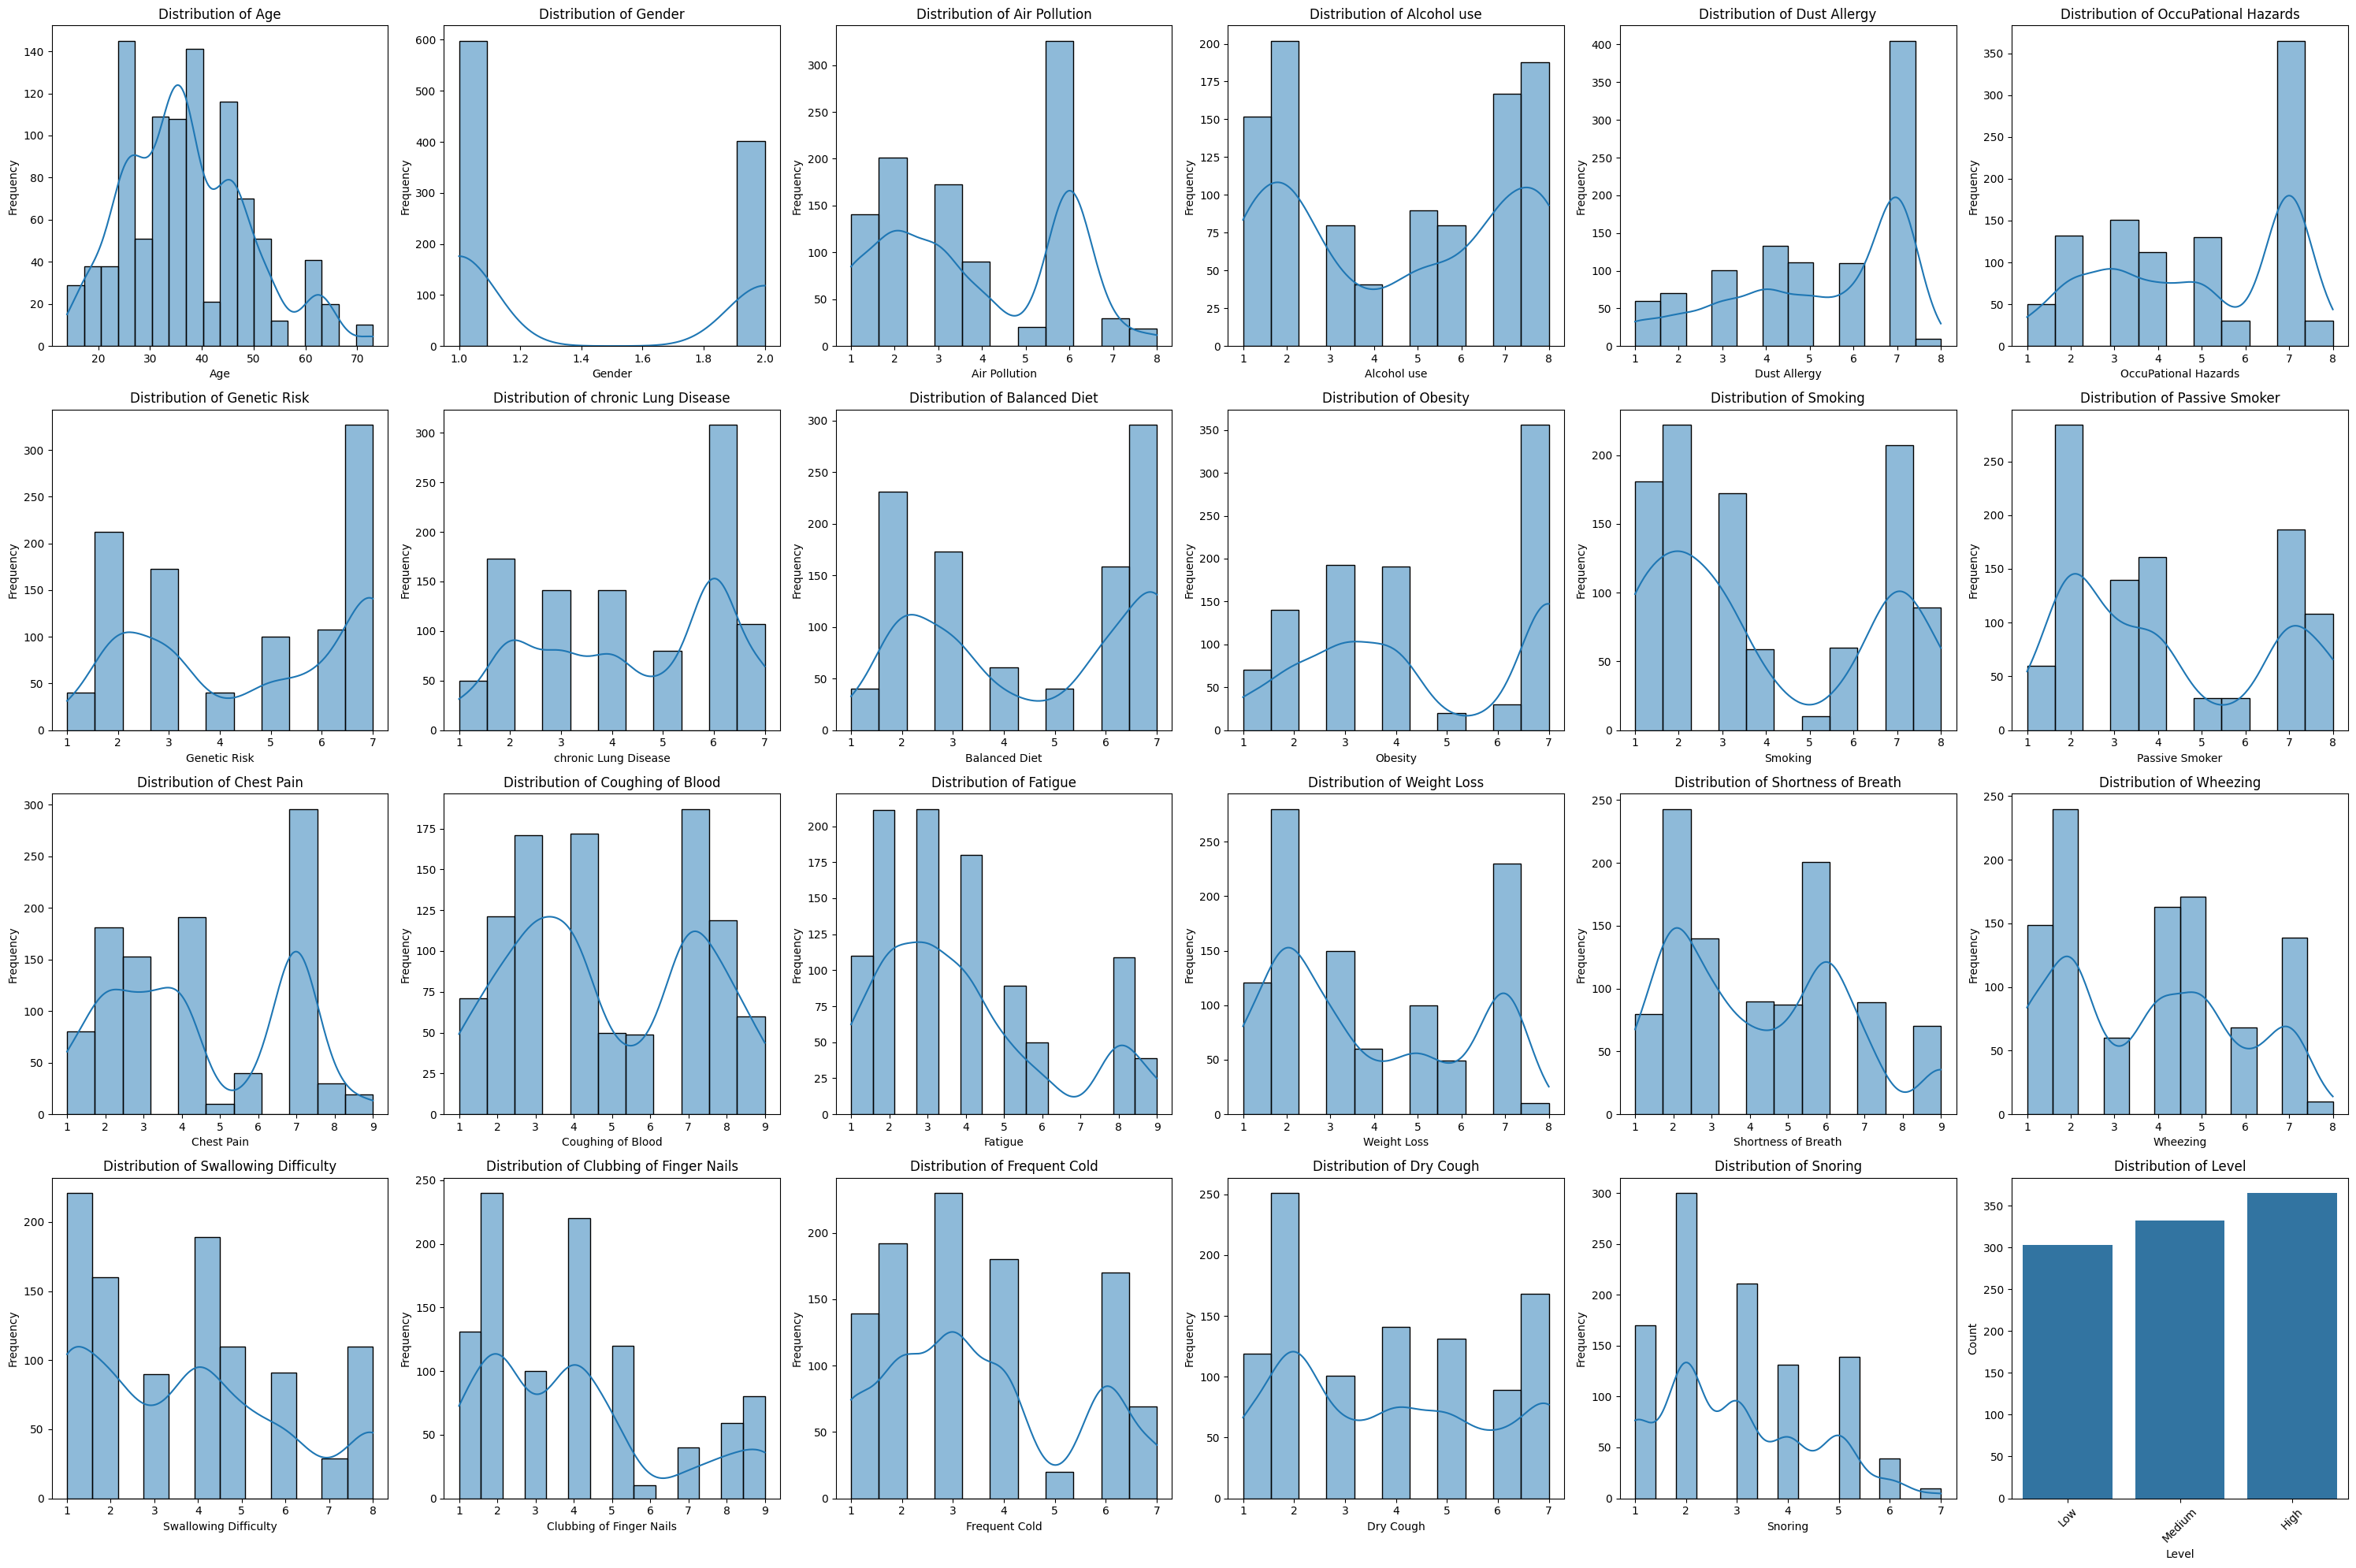

In [ ]:
sample_dataset = dataset.drop(['index', 'Patient Id'], axis=1)

num_cols = 6
num_rows = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 20))

axes = axes.flatten()
plot_idx = 0

for column in sample_dataset.columns:
    ax = axes[plot_idx]

    if sample_dataset[column].dtype == 'object':
        sns.countplot(x=column, data=dataset, ax=ax)  # Plot count plot on the specific subplot
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for clarity
    else:  # If column is numerical
        sns.histplot(sample_dataset[column], kde=True, ax=ax)  # Histogram with KDE
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plot_idx += 1

# Remove any extra subplots if there are fewer columns than grid spaces
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to minimize overlap
plt.tight_layout()
plt.show()


**Checking if the dataset is balanced**


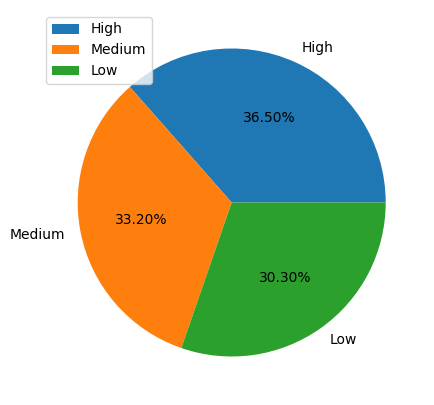

In [ ]:
tdf=dataset['Level'].value_counts().reset_index()
plt.figure(figsize=(15,5))
plt.pie(x=tdf['count'],labels=tdf['Level'],autopct='%.2f%%')
plt.legend(tdf['Level'])
plt.show()

*The Level of risk is equally distribued, therefore the dataset is balanced*

# **Data Preprocessing**

Dropping index and patient id

In [ ]:
sample_dataset = dataset.drop(['index', 'Patient Id'], axis=1)

Encoding target

In [ ]:
sample_dataset['Level'] = sample_dataset['Level'].apply(lambda x: 0 if x=='Low' else 1 if x=='Medium' else 2)

Correlation analysis

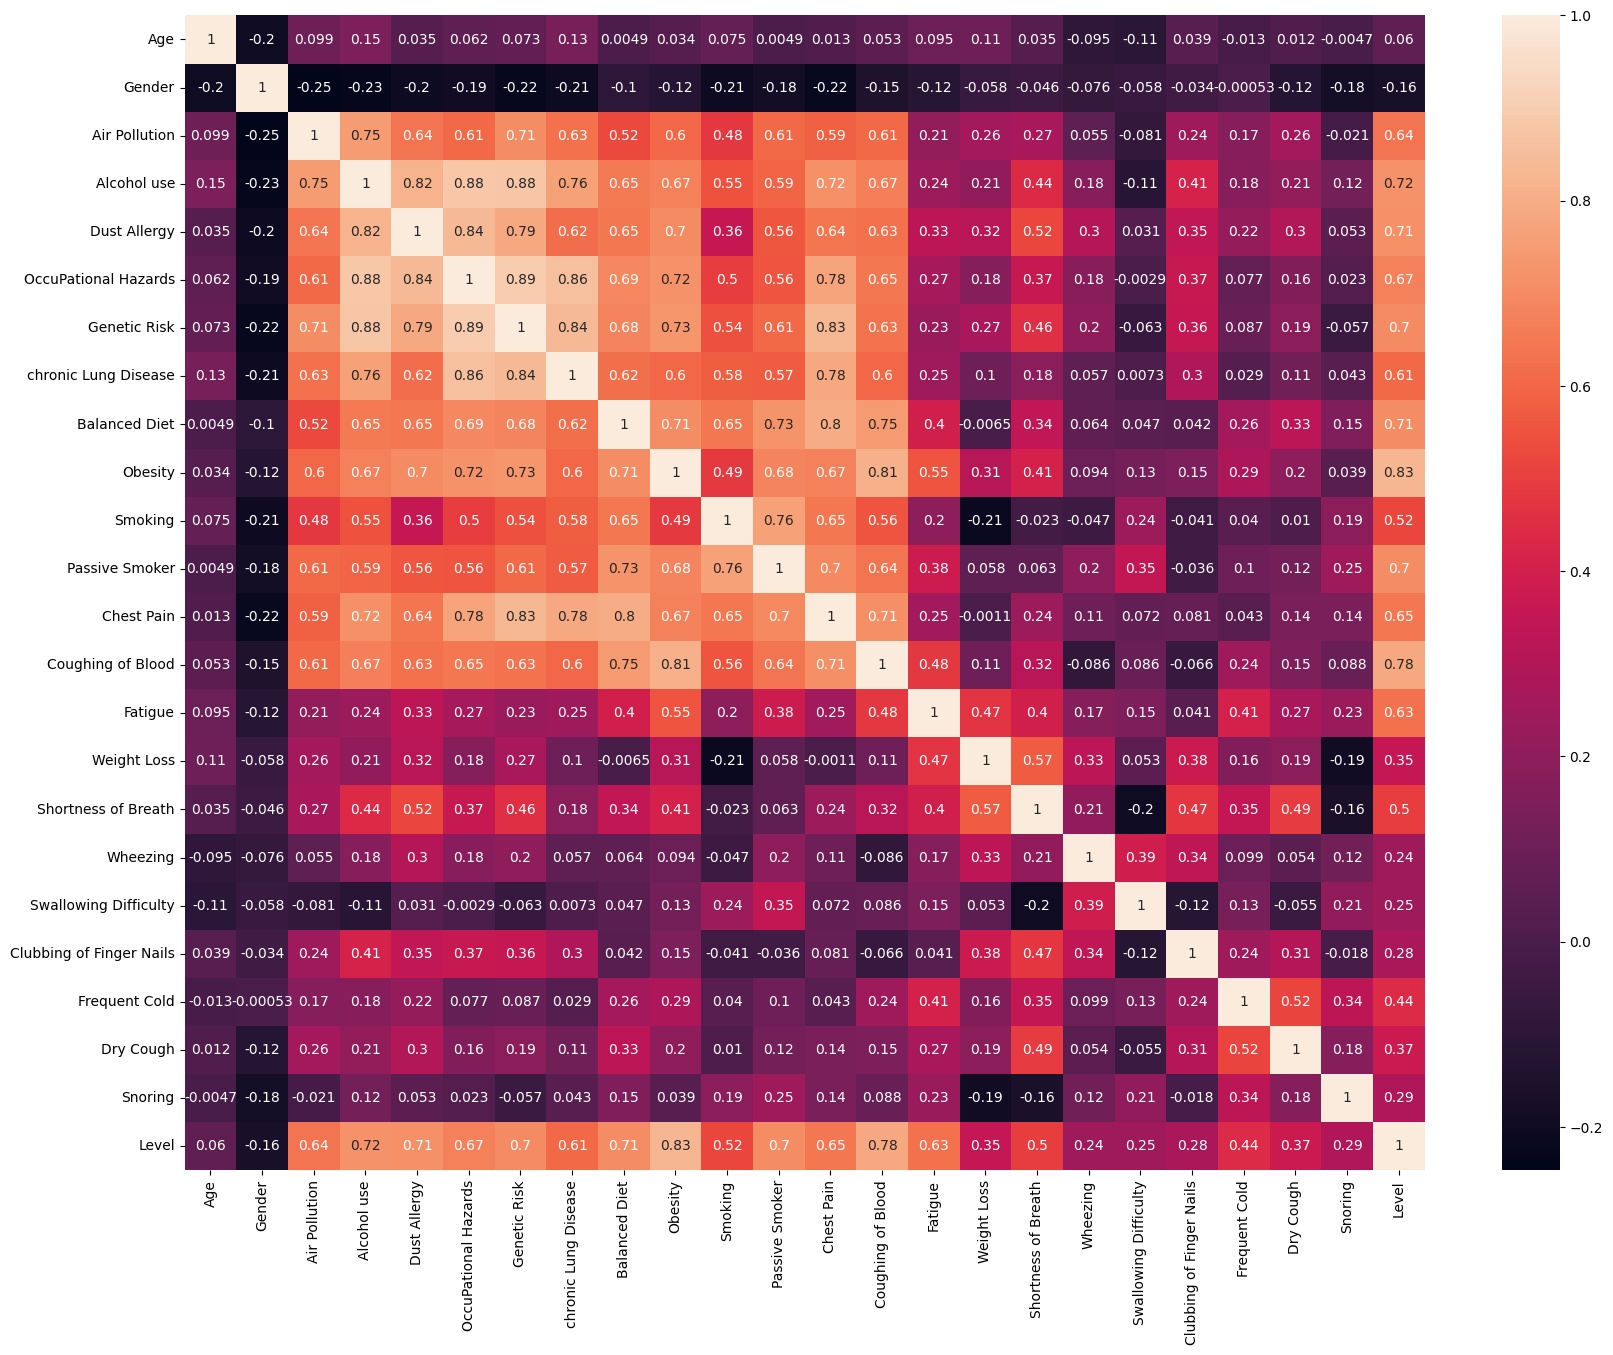

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(sample_dataset.corr(),annot=True,cbar='magma')
plt.show()

Separating features and targets

In [ ]:
from sklearn.model_selection import train_test_split

X = sample_dataset.drop('Level', axis=1)
y = sample_dataset['Level']

X.shape, y.shape

((1000, 23), (1000,))

**Calculating Mutual information of various attributes**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False).reset_index(drop=True)

In [ ]:
print(mi_df)

                     Feature  Mutual Information
0             Passive Smoker            0.605189
1          Coughing of Blood            0.583619
2                Alcohol use            0.540715
3                    Obesity            0.515646
4                   Wheezing            0.512751
5                 Chest Pain            0.493748
6              Balanced Diet            0.488287
7               Dust Allergy            0.450214
8        Shortness of Breath            0.435292
9              Air Pollution            0.430376
10      OccuPational Hazards            0.415418
11                   Smoking            0.407631
12              Genetic Risk            0.399548
13      chronic Lung Disease            0.385026
14                   Fatigue            0.364762
15                       Age            0.363940
16  Clubbing of Finger Nails            0.257841
17                 Dry Cough            0.256135
18             Frequent Cold            0.252447
19               Wei

# **Mutual information of Risk Factors**

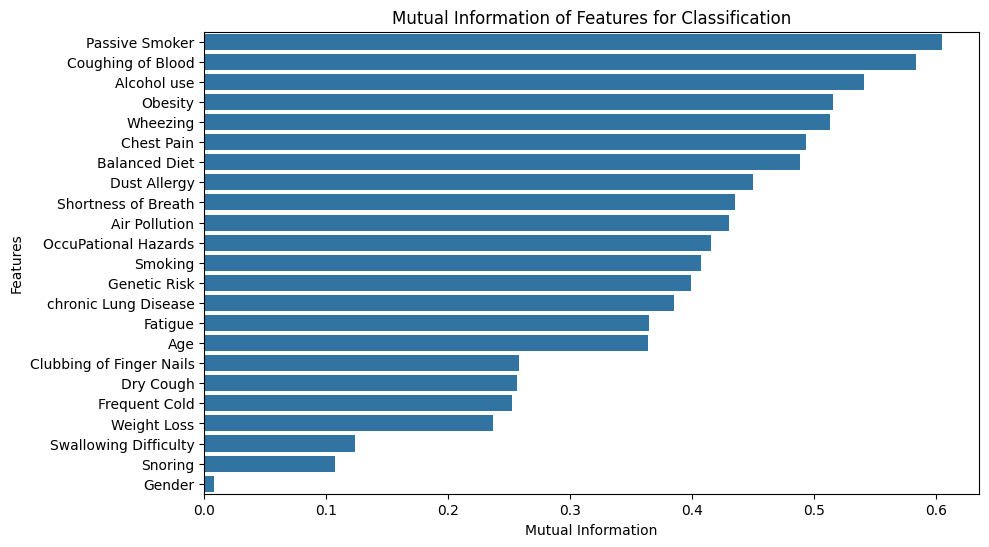

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x='Mutual Information',y='Feature', data=mi_df)
plt.title('Mutual Information of Features for Classification')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()

Splitting the dataset 75% - training, 25% - testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train ,X_test,y_train ,y_test = train_test_split(X, y, test_size=0.25, random_state= 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 23), (250, 23), (750,), (250,))

# **BASELINE MODEL DEVELOPMENT**

# KNN classifier

In [ ]:
knn=KNeighborsClassifier()
params={'n_neighbors':list(np.arange(2,50))}
nknn=RandomizedSearchCV(knn, n_jobs=-1, random_state=20, scoring='accuracy', param_distributions=params,cv=10) #Finding Best K
nknn.fit(X_train,y_train)
print(nknn.best_params_)
print(nknn.best_score_)
nknn=nknn.best_estimator_

{'n_neighbors': 6}
0.9986666666666666


**Classification report for KNN classifier**

In [ ]:
cm_t=[] #To store confusion matrices for training set
cm=[] #To store confusion matrices for training set
pred_t = nknn.predict(X_train)  #Predicting on the training set
pred=nknn.predict(X_test)  #Predicting on the testing set
print('KNN Training Accuracy: ', accuracy_score(y_train,pred_t))
print('KNN Testing Accuracy: ', accuracy_score(y_test,pred))
print('\nClassification Report for KNN Classifier:\n\n ',classification_report(y_test,pred))
cmk_t = confusion_matrix(y_train ,pred_t)
cm_t.append(cmk_t)
cmk=confusion_matrix(y_test,pred)
cm.append(cmk)

KNN Training Accuracy:  0.9986666666666667
KNN Testing Accuracy:  0.996

Classification Report for KNN Classifier:

                precision    recall  f1-score   support

           0       1.00      0.98      0.99        66
           1       0.99      1.00      0.99        80
           2       1.00      1.00      1.00       104

    accuracy                           1.00       250
   macro avg       1.00      0.99      1.00       250
weighted avg       1.00      1.00      1.00       250



# Decision tree Classifier

In [ ]:
dt = DecisionTreeClassifier()
path = dt.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas
params = {'ccp_alpha':alphas}
ndt = GridSearchCV(dt,param_grid=params,n_jobs=-1,scoring='accuracy',cv=10)  # Finding Best Alpha
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
best_alpha = ndt.best_params_['ccp_alpha']

{'ccp_alpha': 0.0}
1.0


In [ ]:
dt=DecisionTreeClassifier(ccp_alpha=best_alpha)
# Hyper Parameter Tuning -> We can use more parameters
params= {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,51)),'min_samples_leaf':list(np.arange(2,51)),
        'max_features':['sqrt','log2',None]}
ndt=RandomizedSearchCV(dt,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
ndt.fit(X_train, y_train)
print(ndt.best_params_)
print(ndt.best_score_)
ndt=ndt.best_estimator_

{'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'entropy'}
0.9946666666666667


**Decision tree classification report**

In [ ]:
pred1_t = ndt.predict(X_train)
pred1 = ndt.predict(X_test)
print('Decision Tree Classifier Training Accuracy: ', accuracy_score(y_train,pred1_t))
print('Decision Tree Classifier Testing Accuracy: ', accuracy_score(y_test,pred1))
print('\nClassification Report for Decision Tree Classifier Classifier:\n\n ', classification_report(y_test,pred1))
cmdt_t = confusion_matrix(y_train, pred1_t)
cm_t.append(cmdt_t)
cmdt = confusion_matrix(y_test, pred1)
cm.append(cmdt)

Decision Tree Classifier Training Accuracy:  0.992
Decision Tree Classifier Testing Accuracy:  0.984

Classification Report for Decision Tree Classifier Classifier:

                precision    recall  f1-score   support

           0       1.00      0.94      0.97        66
           1       0.95      1.00      0.98        80
           2       1.00      1.00      1.00       104

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
params = {'criterion':['gini','entropy'],'min_samples_split':list(np.arange(2,41)),'min_samples_leaf':list(np.arange(2,41)),
        'max_features':['sqrt','log2',None],'n_estimators':[1000]}
nrf = RandomizedSearchCV(rf,param_distributions=params,scoring='accuracy',random_state=42,n_jobs=-1,cv=10)
nrf.fit(X_train, y_train)
print(nrf.best_params_)
print(nrf.best_score_)
nrf = nrf.best_estimator_

{'n_estimators': 1000, 'min_samples_split': 27, 'min_samples_leaf': 6, 'max_features': 'log2', 'criterion': 'entropy'}
1.0


**Classification report for Random forest classifier**

In [ ]:
pred2_t = nrf.predict(X_train)
pred2 =  nrf.predict(X_test)  #Predicting on the testing set
print('Random Forest Classifier Training Accuracy: ',accuracy_score(y_train, pred2_t))
print('Random Forest Classifier Testing Accuracy: ',accuracy_score(y_test, pred2))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ',classification_report(y_test, pred2))
cmrf_t = confusion_matrix(y_train, pred2_t)
cm_t.append(cmrf_t)
cmrf = confusion_matrix(y_test, pred2)
cm.append(cmrf)

Random Forest Classifier Training Accuracy:  1.0
Random Forest Classifier Testing Accuracy:  1.0

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00       104

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



# AdaBoost Classifier

In [ ]:
ada = AdaBoostClassifier(algorithm='SAMME')
params = {
    'n_estimators': [300],
    'learning_rate': np.arange(0.01, 2.01, 0.01),}

nada = RandomizedSearchCV(ada,param_distributions=params,cv=10,n_jobs=-1,scoring='accuracy')
nada.fit(X_train, y_train)
print(nada.best_params_)
print(nada.best_score_)
nada=nada.best_estimator_

{'n_estimators': 300, 'learning_rate': 1.29}
0.9946666666666667


**Classification report for AdaBoost classifier**

In [ ]:
pred3_t = nada.predict(X_train)
pred3 = nada.predict(X_test)
print('AdaBoost Classifier Training Accuracy: ',accuracy_score(y_train,pred3_t))
print('Adaboost Classifier Testing Accuracy: ',accuracy_score(y_test,pred3))
print('\nClassification Report for Random Forest Classifier Classifier:\n\n ', classification_report(y_test, pred2))
cmada_t = confusion_matrix(y_train, pred3_t)
cm_t.append(cmada_t)
cmada = confusion_matrix(y_test, pred3)
cm.append(cmada)

AdaBoost Classifier Training Accuracy:  1.0
Adaboost Classifier Testing Accuracy:  1.0

Classification Report for Random Forest Classifier Classifier:

                precision    recall  f1-score   support

           0       1.00      1.00      1.00        66
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00       104

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



# **Visualization of combined confusion matrices**

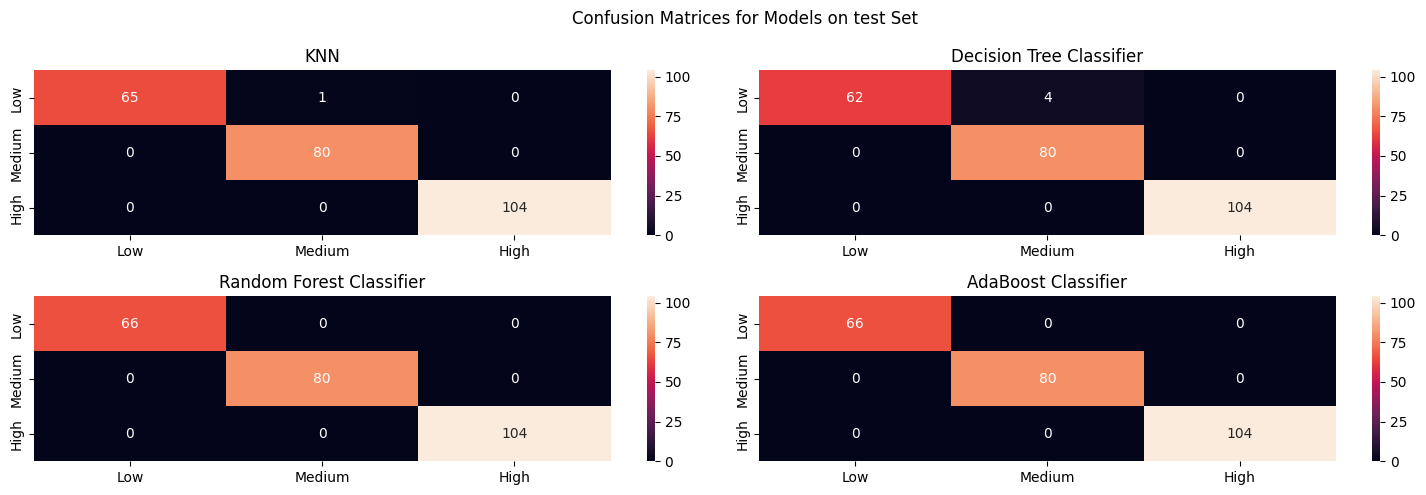

In [ ]:
mods = ['KNN','Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier']
labels = ['Low','Medium','High']
fig,ax = plt.subplots(2,2,figsize=(15,5))
r=0
c=0
for i,mod in enumerate(mods):
    sns.heatmap(cm[i],annot=True,fmt='d',ax=ax[r][c],xticklabels=labels,yticklabels=labels)
    ax[r][c].set_title(mod)
    c+=1
    if(c==2):
        r+=1
        c=0
plt.suptitle('Confusion Matrices for Models on test Set')
plt.tight_layout()
plt.show()

# ANN Classifier

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4019 - loss: 4.6891 - val_accuracy: 0.4000 - val_loss: 1.8789
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4774 - loss: 2.6734 - val_accuracy: 0.6400 - val_loss: 0.7361
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5710 - loss: 1.8808 - val_accuracy: 0.6333 - val_loss: 0.8715
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5480 - loss: 1.5366 - val_accuracy: 0.6867 - val_loss: 0.6283
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5975 - loss: 1.1055 - val_accuracy: 0.6933 - val_loss: 0.6354
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5665 - loss: 0.9965 - val_accuracy: 0.7200 - val_loss: 0.6221
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6203 - loss: 0.9273 - val_accuracy: 0.7267 - val_loss: 0.6265
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6149 - loss: 0.7774 - val_accuracy: 0.7400 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        66
           1       0.95      0.99      0.97        80
           2       0.99      1.00      1.00       104

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



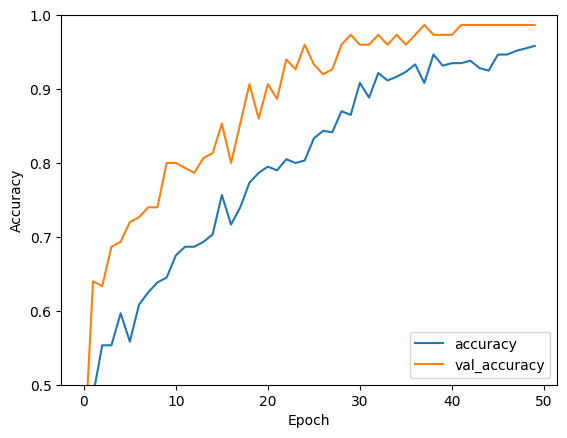

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes and softmax activation


model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()